In [3]:
import codecs
import re
from os import listdir
from os.path import join

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
# listing 3.4 - Deep Learning for Natural Language Processing

def save_embedding(outputFile, weights, vocabulary):
    rev = {v: k for k, v in iter(vocabulary.items())}
    with codecs.open(outputFile, "w") as f:
        f.write(str(len(vocabulary)) + " " + str(weights.shape[1]) + "\n")
        for index in sorted(iter(rev.keys())):
            word = rev[index]
            f.write(word + " ")
            for i in list(range(len(weights[index]))):
                f.write(str(weights[index][i]) + " ")
            f.write("\n")


In [6]:
vocab_file = "data/aclImdb/imdb.vocab"
label_to_id = {'<unk>': 0, '<pad>': 1}

with open(vocab_file, 'r') as f:
    for (idx, line) in enumerate(f):
        line_trim = line.rstrip()
        label_to_id[line_trim] = idx + 2 # add 2 to account for <unk> and <pad>


In [7]:
def get_text(file_name): return open(file_name, 'r').read()


In [8]:
dataset_dir = "data/aclImdb"

split_names = ["train", "test"]
group_names = ["pos", "neg"]
column_names = ["text", "label"]

datasets = [{"text": [], "label": []}, {"text": [], "label": []}]


# loop over each dataset
for split in split_names:
    ds_idx = 0 if split == "train" else 1

    # loop over each group
    for group in group_names:
        label = 1 if group == "pos" else 0
        onlyfiles = [f for f in listdir(join(dataset_dir, split, group))]

        # loop over each file in the group
        for file_name in onlyfiles:
            # extract the text from the file
            text = get_text(join(dataset_dir, split, group, file_name))

            # clean the text
            text = re.sub(
                r'[!"#\$%&\(\)\*\+,-\.\/:;<=>\?@\[\\\]\^_`{\|}~\t\n|\'s]+', '', text)
            text = [label_to_id[word]
                    if word in label_to_id else 0 for word in text.lower().split(' ')]

            # add the text and label to the dataframe
            datasets[ds_idx]["text"].append(text)
            datasets[ds_idx]["label"].append(label)

[ds_train, ds_test] = datasets


In [9]:
max_len = 50

x_train = pad_sequences(ds_train["text"], maxlen=max_len, padding='post', value=1)
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(ds_train["label"])

x_test = pad_sequences(ds_test["text"], maxlen=max_len, padding='post', value=1)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(ds_test["label"])

2021-11-11 01:49:48.075590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 01:49:48.081375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 01:49:48.081696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 01:49:48.082391: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
def model_fn(hp):
    global embedding

    hp_embed = hp.Int('embed', min_value=50, max_value=200, step=34)
    hp_lr = hp.Float('lr', min_value=0.00001, max_value=0.0001, step=0.00004)

    model = Sequential()
    embedding = Embedding(len(label_to_id), hp_embed, input_length=max_len)
    model.add(embedding)
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer=Adam( learning_rate=hp_lr), metrics=['acc'])

    

    return model


In [16]:
tuner = kt.Hyperband(model_fn,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='tuning',
                     project_name='sentimate_embedding',
                     seed=42)

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', patience=10)
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
embed {best_hps.get('embed')}
lr {best_hps.get('lr')}.
""")


Trial 14 Complete [00h 00m 15s]
val_loss: 0.6238117218017578

Best val_loss So Far: 0.6238117218017578
Total elapsed time: 00h 02m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
embed 186
lr 9e-05.



In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1)

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_data=(
    x_test, y_test), epochs=100, verbose=1, shuffle=True, callbacks=[es, mc])


Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 0.6891 - acc: 0.5657
Epoch 00001: val_loss improved from inf to 0.68218, saving model to best_model.h5
782/782 [==============================] - 8s 10ms/step - loss: 0.6891 - acc: 0.5657 - val_loss: 0.6822 - val_acc: 0.6372
Epoch 2/100
781/782 [============================>.] - ETA: 0s - loss: 0.6477 - acc: 0.7484
Epoch 00002: val_loss improved from 0.68218 to 0.62595, saving model to best_model.h5
782/782 [==============================] - 8s 10ms/step - loss: 0.6477 - acc: 0.7484 - val_loss: 0.6259 - val_acc: 0.7139
Epoch 3/100
781/782 [============================>.] - ETA: 0s - loss: 0.5543 - acc: 0.7803
Epoch 00003: val_loss improved from 0.62595 to 0.54162, saving model to best_model.h5
782/782 [==============================] - 8s 10ms/step - loss: 0.5542 - acc: 0.7804 - val_loss: 0.5416 - val_acc: 0.7528
Epoch 4/100
781/782 [============================>.] - ETA: 0s - loss: 0.4658 - acc: 0.8136
Epoch 00004:

In [19]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 78.97%


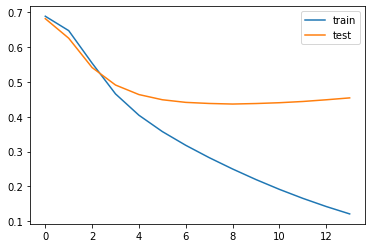

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
save_embedding("embedding_labeled.txt", embedding.get_weights()[0], label_to_id)